In [1]:
# 4/19 for checking that the denoising graph autoencoder model works! 

import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch_geometric.data import Data, DataLoader  # PyG Data and loader
from torch.optim import Adam, SGD
import matplotlib.pyplot as plt 

from collections import defaultdict
import numpy.ma as ma
from scipy.optimize import linear_sum_assignment

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


Downsampled MNIST tensor shape: torch.Size([14, 14])


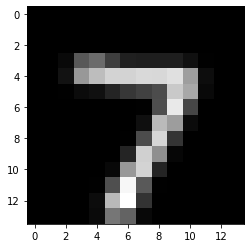

In [2]:
# Define the transform to downsample the images to 14x14 pixels
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((14, 14)),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the MNIST dataset with the downsampling transform
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# # Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

test_features, test_labels = next(iter(test_loader))
true = test_features[0].squeeze()
plt.imshow(true, cmap="gray")
print(f"Downsampled MNIST tensor shape: {true.shape}")

In [3]:
# Define MNIST classifier MLP class for dataset
class MLP(nn.Module):
    def __init__(self, init_type='xavier', seed=None):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(196, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, 10)
        
        if seed is not None:
            torch.manual_seed(seed)  # Set a unique seed for reproducibility

        self.init_weights(init_type)

    def init_weights(self, init_type):
        if init_type == 'xavier':
            nn.init.xavier_uniform_(self.fc1.weight)
            nn.init.xavier_uniform_(self.fc2.weight)
            nn.init.xavier_uniform_(self.fc3.weight)
        elif init_type == 'he':
            nn.init.kaiming_uniform_(self.fc1.weight, nonlinearity='relu')
            nn.init.kaiming_uniform_(self.fc2.weight, nonlinearity='relu')
            nn.init.kaiming_uniform_(self.fc3.weight, nonlinearity='relu')
        else:
            nn.init.normal_(self.fc1.weight)
            nn.init.normal_(self.fc2.weight)
            nn.init.normal_(self.fc3.weight)
        
        nn.init.zeros_(self.fc1.bias)
        nn.init.zeros_(self.fc2.bias)
        nn.init.zeros_(self.fc3.bias)

    def forward(self, x):
        x = x.view(-1, 196)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    
def test_mlp(model, test_loader, device = device):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():  # No need to compute gradients for evaluation
        for data, target in test_loader:
            output = model(data)
            _, predicted = torch.max(output, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    
    accuracy = 100 * correct / total
    return accuracy

def train_mlp(model, epochs=3):
    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=1e-3)
    
    model.train()
    for epoch in range(epochs):
        for data, target in train_loader:
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

In [5]:
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv
from torch_geometric.nn import GCNConv, BatchNorm, JumpingKnowledge, GraphNorm, GATConv, GAT
import time


# Git Rebasin Stuff: 

In [6]:
# Functions for permutations and weight matching
def permute_layer_weights(layer, perm):
    """Permutes weights and biases of a layer based on the given permutation matrix."""
    weight = layer.weight.data.clone()
    bias = layer.bias.data.clone()

    # Permute rows of weights (output dimension)
    layer.weight.data = weight[perm, :]

    # Permute bias (output dimension)
    layer.bias.data = bias[perm]
    return layer

def permute_model(model, permutations):
    """Applies a list of permutations to a model's layers."""
    permute_layer_weights(model.fc1, permutations[0])
    permute_layer_weights(model.fc2, permutations[1])

    # Adjust input weights of the second hidden layer
    model.fc2.weight.data = model.fc2.weight.data[:, permutations[0]]
    # Adjust input weights of the output layer
    model.fc3.weight.data = model.fc3.weight.data[:, permutations[1]]
    return model

# Functions to permute weights and adjust input weights
def apply_permutation(layer, perm):
    """
    Applies the given permutation to the weights and biases of a layer.
    Args:
        layer: The layer to permute.
        perm: The permutation array.
    """
    # Permute rows (output dimension) of weights
    layer.weight.data = layer.weight.data[perm, :]
    # Permute biases
    layer.bias.data = layer.bias.data[perm]

def adjust_input_weights(layer, perm):
    """
    Adjusts the input wei
    ghts of a layer according to the permutation of the previous layer.
    Args:
        layer: The layer to adjust.
        perm: The permutation array of the previous layer.
    """
    layer.weight.data = layer.weight.data[:, perm]
    
def generate_permutation_matrix(hidden_dim):
    """Generates a random permutation matrix."""
    perm = np.random.permutation(hidden_dim)
    return torch.tensor(perm, dtype=torch.long)

def compute_similarity_matrix(weights_a, weights_b):
    """
    Computes the similarity matrix for two layers' weights.
    """
    weights_a = weights_a.view(weights_a.size(0), -1)
    weights_b = weights_b.view(weights_b.size(0), -1)
    return torch.matmul(weights_a, weights_b.T)

def get_permuted_weights(weights, perm):
    """
    Permutes the rows of weights based on the given permutation.
    """
    return weights[perm, :]


def weight_matching(rng, model_a, model_b, max_iter=100, init_perm=None):
    """
    Optimizes permutations to match Model B to Model A.
    """
    layers = ['fc1', 'fc2', 'fc3']
    perm_sizes = {layer: getattr(model_a, layer).weight.size(0) for layer in layers[:-1]}
    perm = {layer: np.arange(size) for layer, size in perm_sizes.items()} if init_perm is None else init_perm

    for iteration in range(max_iter):
        progress = False
        for layer in layers[:-1]:  # Exclude the output layer (fc3)
            n = perm_sizes[layer]
            similarity_matrix = compute_similarity_matrix(
                getattr(model_a, layer).weight.data,
                get_permuted_weights(getattr(model_b, layer).weight.data, perm[layer])
            )
            row_ind, col_ind = linear_sum_assignment(similarity_matrix.numpy(), maximize=True)

            old_score = np.sum(similarity_matrix.numpy()[np.arange(n), perm[layer]])
            new_score = np.sum(similarity_matrix.numpy()[np.arange(n), col_ind])

            if new_score > old_score:
                perm[layer] = col_ind
                progress = True

        if not progress:
            break

    return perm, new_score

def rebase_model_b_to_a(rng, model_a, model_b, max_iter=100):
    """
    Rebases Model B to match Model A using weight matching.
    """
    # Generate initial permutations
    init_perm = {layer: generate_permutation_matrix(getattr(model_a, layer).weight.size(0)) for layer in ['fc1', 'fc2']}
    
    # Perform weight matching
    permutations, score = weight_matching(rng, model_a, model_b, max_iter=max_iter, init_perm=init_perm)
    
    # Apply the permutations to Model B
    model_b = permute_model(model_b, [permutations['fc1'], permutations['fc2']])
    
    return model_b, permutations, score

def load_model_weights(model, weight_path):
    # Load weights and biases
    weights, biases = torch.load(weight_path)
    model.fc1.weight.data = weights[0]
    model.fc2.weight.data = weights[1]
    model.fc3.weight.data = weights[2]
    model.fc1.bias.data = biases[0]
    model.fc2.bias.data = biases[1]
    model.fc3.bias.data = biases[2]
    return model

def reconstruct_model(model, final_permutations):
    """
    Reconstruct model_b by applying the final permutations to its layers.
    Args:
        model_b (MLP): The model to be reconstructed.
        final_permutations (dict): Dictionary containing layer-wise permutations.
    Returns:
        MLP: The reconstructed model.
    """
    # Apply permutations to fc1 layer
    apply_permutation(model.fc1, final_permutations[1]['fc1'])
    adjust_input_weights(model.fc2, final_permutations[1]['fc1'])
    
    # Apply permutations to fc2 layer
    apply_permutation(model.fc2, final_permutations[1]['fc2'])
    adjust_input_weights(model.fc3, final_permutations[1]['fc2'])
    
    # Return the reconstructed model
    return model

def extract_weights_and_biases(model):
    """Flatten the weights and biases of each layer in the model into a single vector."""
    all_weights_biases = []
    
    # Flatten weights and biases for each layer
    for layer_name in ['fc1', 'fc2', 'fc3']:
        weights = getattr(model, layer_name).weight.data.numpy().flatten()  # Flatten the weights
        biases = getattr(model, layer_name).bias.data.numpy().flatten()    # Flatten the biases
        all_weights_biases.extend(weights)
        all_weights_biases.extend(biases)
    
    return np.array(all_weights_biases)

def get_permuted_models_data(ref_point=0, N = 10, path = f"models/reduced_mlp_weights_{0}.pt"):
    ref_model = MLP()
    ref_model_path = path #f"models/reduced_mlp_weights_{ref_point}.pt"
#     ref_model_path =   f"models/dropout_mlp_weights_{ref_point}.pt"

    ref_model = load_model_weights(ref_model, ref_model_path)
    
    org_models=[]
    permuted_models = []
    full_times = []
    rebasin_times = []
    scores = []
    rng = np.random.default_rng(42)

    for i in range(0,N):
        if i == ref_point:
            continue
        all_start = time.time() # start timing
        model_path = f"models/reduced_mlp_weights_{i}.pt"
#         model_path = f"models/dropout_mlp_weights_{i}.pt"
        
        model = MLP()
        model = load_model_weights(model, model_path)
        org_models.append(model)
        loaded_model = time.time() # end timing for loading the model from .pth file
        
        reconstructed_model, final_permutations, score = rebase_model_b_to_a(rng, ref_model, model, max_iter=100)
        scores.append(score)
        permuted_models.append(reconstructed_model)
        all_end = time.time() # end timing for the entire loop
        
        full_times.append(all_end - all_start)
        rebasin_times.append(all_end - loaded_model)
        
#         print(f"Org model accuracy:{test_mlp(model, test_loader)} Reconstructed model accuracy:{test_mlp(reconstructed_model, test_loader)}")
    return org_models, permuted_models, scores, rebasin_times


In [7]:
org_models, permuted_models, scores, rebasin_times = get_permuted_models_data(ref_point=0, N = 1200) # dropout = 180, norm = 780

In [8]:
class MLPGraphDatasetNeuronsFromList(torch.utils.data.Dataset):
    def __init__(self, mlp_list):
        """
        mlp_list: a list of MLP objects.
        """
        self.models = mlp_list

    def __len__(self):
        return len(self.models)

    def __getitem__(self, idx):
        # Get the MLP instance from the list.
        mlp = self.models[idx]
        # Extract weights and biases directly from the model's layers.
        # We assume the model has attributes fc1, fc2, fc3.
        weights = [mlp.fc1.weight, mlp.fc2.weight, mlp.fc3.weight]
        biases = [mlp.fc1.bias, mlp.fc2.bias, mlp.fc3.bias]

        # --- Build Node Features ---
        # Input layer: create nodes based on the input dimension of fc1.
        input_dim = weights[0].shape[1]
        input_feats = torch.zeros(input_dim, 1)
        # For subsequent layers, use the bias of each layer as the node feature.
        node_features = [input_feats]
        for b in biases:
            node_feats = b.view(-1, 1)
            node_features.append(node_feats)
        # Concatenate features from all layers; total nodes = input_dim + sum(layer output sizes)
        x = torch.cat(node_features, dim=0)

        # --- Build Edges and Edge Attributes ---
        edge_index_list = []
        edge_attr_list = []
        offset = 0  # starting index for current layer's nodes
        # Iterate over each weight matrix corresponding to a layer.
        for w in weights:
            in_dim = w.shape[1]    # number of nodes in source layer
            out_dim = w.shape[0]   # number of nodes in destination layer
            src_offset = offset
            dst_offset = offset + in_dim
            for i_out in range(out_dim):
                for j_in in range(in_dim):
                    src = src_offset + j_in
                    dst = dst_offset + i_out
                    edge_index_list.append([src, dst])
                    edge_attr_list.append([w[i_out, j_in].item()])
            offset += in_dim  # move the offset for the next layer

        # Convert lists to torch tensors.
        edge_index = torch.tensor(edge_index_list, dtype=torch.long).t().contiguous()
        edge_attr = torch.tensor(edge_attr_list, dtype=torch.float)

        return Data(x=x, edge_index=edge_index, edge_attr=edge_attr)


In [9]:
dataset = MLPGraphDatasetNeuronsFromList(permuted_models)
loader = DataLoader(dataset, batch_size=64, shuffle=True)

# Build Denoising Graph Autoencoder 

In [10]:
from torch_geometric.nn import NNConv, GraphNorm

# -----------------------------------------------------------------------------
# 2) Encoder: edge‐conditioned graph conv with residuals & normalization
# -----------------------------------------------------------------------------
class EdgeConditionedEncoder(nn.Module):
    def __init__(self, in_ch, hidden_ch, latent_dim):
        super().__init__()
        # MLP to produce per-edge weight kernels
        self.edge_mlp1 = nn.Sequential(
            nn.Linear(1, in_ch * hidden_ch),
            nn.ReLU(),
            nn.Linear(in_ch * hidden_ch, in_ch * hidden_ch)
        )
        self.conv1 = NNConv(in_ch, hidden_ch, self.edge_mlp1, aggr='mean')
        self.norm1 = GraphNorm(hidden_ch)

        self.edge_mlp2 = nn.Sequential(
            nn.Linear(1, hidden_ch * hidden_ch),
            nn.ReLU(),
            nn.Linear(hidden_ch * hidden_ch, hidden_ch * hidden_ch)
        )
        self.conv2 = NNConv(hidden_ch, hidden_ch, self.edge_mlp2, aggr='mean')
        self.norm2 = GraphNorm(hidden_ch)

        # final mapping to latent space
        self.lin = nn.Linear(hidden_ch, latent_dim)

    def forward(self, x, edge_index, edge_weight):
        ew = edge_weight.view(-1,1)  # [E,1]
        h0 = x
        h  = F.relu(self.norm1(self.conv1(x, edge_index, ew)))
        h  = h + h0                        # residual
        h1 = h
        h  = F.relu(self.norm2(self.conv2(h, edge_index, ew)))
        h  = h + h1                        # residual
        z  = self.lin(h)                   # [N, latent_dim]
        return z

# -----------------------------------------------------------------------------
# 3) Joint Decoder: reconstruct both edge weights & node features
# -----------------------------------------------------------------------------
class JointDecoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim=64):
        super().__init__()
        # project node embeddings
        self.node_proj   = nn.Linear(latent_dim, hidden_dim)
        # project raw edge weights
        self.edge_proj   = nn.Linear(1, hidden_dim)
        # MLP heads
        self.edge_h1     = nn.Linear(hidden_dim, hidden_dim)
        self.edge_out    = nn.Linear(hidden_dim, 1)
        self.node_h1     = nn.Linear(hidden_dim, hidden_dim)
        self.node_out    = nn.Linear(hidden_dim, 1)

    def forward(self, z, edge_index, edge_weight):
        # z: [N, latent_dim]
        # edge_index: [2, E], edge_weight: [E,1] or [E]
        if edge_weight.dim() == 1:
            ew = edge_weight.unsqueeze(1)
        else:
            ew = edge_weight  # [E,1]

        # project node embeddings
        h_n = F.relu(self.node_proj(z))           # [N, H]

        # build edge-specific features
        src, dst = edge_index
        h_e = h_n[src] + h_n[dst]                  # [E, H]
        h_ew = F.relu(self.edge_proj(ew))          # [E, H]
        h_comb = F.relu(h_e + h_ew)                # [E, H]

        # edge reconstruction
        he = F.relu(self.edge_h1(h_comb))
        edge_pred = self.edge_out(he).squeeze()    # [E]

        # node reconstruction
        hn = F.relu(self.node_h1(h_n))
        node_pred = self.node_out(hn).squeeze()    # [N]

        return edge_pred, node_pred

# -----------------------------------------------------------------------------
# 4) Graph Autoencoder wrapper
# -----------------------------------------------------------------------------
class GraphAutoEncoder(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, data):
        z = self.encoder(data.x, data.edge_index, data.edge_attr.view(-1))
        return z

    def compute_loss(self, data):
        z = self.encoder(data.x, data.edge_index, data.edge_attr.view(-1))
        ep, npred = self.decoder(z, data.edge_index, data.edge_attr.view(-1))
        loss_e = F.mse_loss(ep, data.edge_attr.view(-1))
        loss_n = F.mse_loss(npred, data.x.view(-1))
        return loss_e + loss_n

In [11]:
# Assume you have a Python list of MLPs called `mlp_list`
# dataset = MLPGraphDatasetNeuronsFromList(mlp_list)
# loader  = DataLoader(dataset, batch_size=8, shuffle=True)


encoder = EdgeConditionedEncoder(in_ch=1,   hidden_ch=16, latent_dim=128)
decoder = JointDecoder(latent_dim=128,        hidden_dim=256)
gae     = GraphAutoEncoder(encoder, decoder)

optimizer = torch.optim.Adam(gae.parameters(), lr=5e-4)

# training loop
for epoch in range(1, 25):
    gae.train()
    total_loss = 0
    for data in loader:
        optimizer.zero_grad()
        loss = gae.compute_loss(data)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch:03d}, Recon Loss: {total_loss/len(loader):.4f}")


Epoch 001, Recon Loss: 0.0185
Epoch 002, Recon Loss: 0.0009
Epoch 003, Recon Loss: 0.0002
Epoch 004, Recon Loss: 0.0001
Epoch 005, Recon Loss: 0.0000
Epoch 006, Recon Loss: 0.0000


KeyboardInterrupt: 

In [12]:
def count_parameters(model):
    """
    Function: Count the learnable params in a portion of the model
    Args: model segment (ie, encoder, decoder, entire model)
    Returns: the number of learnable params in that model/segment
    """
    total_params = sum(p.numel() for p in model.parameters())
    return total_params

print(f"Denoising GAE has {count_parameters(gae)} parameters")

Denoising GAE has 234818 parameters


# Examine performance: 

In [15]:
import torch
from torch_geometric.data import Data

def vgae_to_mlp(generated_data):
    """
    generated_data: a Data object that has the reconstructed node features (x)
    and edge attributes (edge_attr).  
    The original graph was built as:
      - First 196 nodes: input layer,
      - Next 32 nodes: fc1 neurons,
      - Next 32 nodes: fc2 neurons,
      - Next 10 nodes: fc3 neurons.
    Edge ordering is:
      - fc1: edges from input (196 nodes) to fc1 (32 nodes) in a nested loop:
             for i in range(32): for j in range(196)
      - fc2: edges from fc1 (32 nodes) to fc2 (32 nodes)
      - fc3: edges from fc2 (32 nodes) to fc3 (10 nodes)
    This function instantiates a new MLP and sets its weights and biases from the generated outputs.
    """
    x_rec = generated_data.x.squeeze()  # shape: (196+32+32+10,)
    edge_attr_rec = generated_data.edge_attr  # shape: (32*196 + 32*32 + 10*32,)

    # Extract biases.
    fc1_bias = x_rec[196:196+32]
    fc2_bias = x_rec[196+32:196+32+32]
    fc3_bias = x_rec[196+32+32:196+32+32+10]

    # Extract edge weights.
    # For fc1: first 32*196 values.
    fc1_weight = edge_attr_rec[:32*196].view(32, 196)
    # For fc2: next 32*32 values.
    start_fc2 = 32*196
    fc2_weight = edge_attr_rec[start_fc2:start_fc2+32*32].view(32, 32)
    # For fc3: remaining 10*32 values.
    start_fc3 = start_fc2 + 32*32
    fc3_weight = edge_attr_rec[start_fc3:start_fc3+10*32].view(10, 32)

    # Create a new instance of the MLP.
    new_mlp = MLP()
    # Assign weights and biases.
    with torch.no_grad():
        new_mlp.fc1.weight.copy_(fc1_weight)
        new_mlp.fc1.bias.copy_(fc1_bias)
        new_mlp.fc2.weight.copy_(fc2_weight)
        new_mlp.fc2.bias.copy_(fc2_bias)
        new_mlp.fc3.weight.copy_(fc3_weight)
        new_mlp.fc3.bias.copy_(fc3_bias)
    return new_mlp


def reconstruct_nth_mlp(gae, dataset, n = 0, device = device):
    """
    Reconstructs the first MLP in `dataset` via your deterministic GAE.
    
    Args:
        gae      : the trained GraphAutoEncoder (with .encoder and .decoder).
        dataset  : your MLPGraphDatasetNeuronsFromList (or equivalent).
        device   : torch.device ('cpu' or 'cuda').
    
    Returns:
        new_mlp  : an MLP instance whose weights & biases were produced
                   by the GAE reconstructions.
    """
    # 1) Grab the first graph
    data = dataset[n]
    data = data.to(device)
    
    # 2) Run through encoder + decoder
    gae.eval()
    with torch.no_grad():
        # encode
        z = gae.encoder(data.x, data.edge_index, data.edge_attr.view(-1))
        # decode edges & nodes
        if hasattr(gae.decoder, 'forward'):
            # JointDecoder interface: returns (edge_pred, node_pred)
            edge_pred, node_pred = gae.decoder(z, data.edge_index, data.edge_attr.view(-1))
        else:
            # If you have separate decoders:
            edge_pred = gae.edge_decoder(z, data.edge_index, data.edge_attr.view(-1))
            node_pred = gae.node_decoder(z, data.edge_index, data.edge_attr.view(-1))
    
    # 3) Build a new Data object with the reconstructions
    rec_data = Data(
        x         = node_pred.unsqueeze(1),      # [N,1]
        edge_index= data.edge_index,             # same topology
        edge_attr = edge_pred.unsqueeze(1)       # [E,1]
    )
    
    # 4) Convert graph back to an MLP
    # This is the same vgae_to_mlp function from before:
    new_mlp = vgae_to_mlp(rec_data)
    return new_mlp


In [16]:
# assuming you have:
#   gae         : your trained GraphAutoEncoder
#   dataset     : your MLPGraphDatasetNeuronsFromList instance
#   device      : torch.device('cuda' or 'cpu')
#   test_loader : your MNIST DataLoader
#   test_mlp    : function(mlp, device, test_loader) -> accuracy/loss

# reconstruct one MLP and immediately test it
generated_mlp = reconstruct_nth_mlp(gae, dataset)
accuracy = test_mlp(generated_mlp, test_loader)
print(f"Reconstructed MLP test accuracy: {accuracy}%")

Reconstructed MLP test accuracy: 92.78%


In [18]:
n = 100
accuracies = []
for i in range(n): 
    generated_mlp = reconstruct_nth_mlp(gae, dataset, i)
    accuracy = test_mlp(generated_mlp, test_loader)
    accuracies.append(accuracy)
    print(f"Reconstructed MLP test accuracy: {accuracy}%")

Reconstructed MLP test accuracy: 92.78%
Reconstructed MLP test accuracy: 91.73%
Reconstructed MLP test accuracy: 92.66%
Reconstructed MLP test accuracy: 93.72%
Reconstructed MLP test accuracy: 91.67%
Reconstructed MLP test accuracy: 90.42%
Reconstructed MLP test accuracy: 92.51%
Reconstructed MLP test accuracy: 93.69%
Reconstructed MLP test accuracy: 85.78%
Reconstructed MLP test accuracy: 93.5%
Reconstructed MLP test accuracy: 93.32%
Reconstructed MLP test accuracy: 93.92%
Reconstructed MLP test accuracy: 93.31%
Reconstructed MLP test accuracy: 93.48%
Reconstructed MLP test accuracy: 92.94%
Reconstructed MLP test accuracy: 92.49%
Reconstructed MLP test accuracy: 92.13%
Reconstructed MLP test accuracy: 93.22%
Reconstructed MLP test accuracy: 93.26%
Reconstructed MLP test accuracy: 93.17%
Reconstructed MLP test accuracy: 89.92%
Reconstructed MLP test accuracy: 90.93%
Reconstructed MLP test accuracy: 93.93%
Reconstructed MLP test accuracy: 91.42%
Reconstructed MLP test accuracy: 91.79%
R

Histogram of 100 first MLP reconstructions' performances on MNIST test data


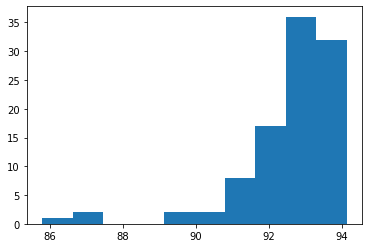

In [20]:
plt.hist(accuracies)
print(f"Histogram of 100 first MLP reconstructions' performances on MNIST test data")